In [1]:
#GC 06/24
#Preps BP3+ climate data for a given climate change scenario. Run on office desktop
#so some file paths may need checking. Note the CC data is quite large (~1TB)
#and lives on an ext. HDD connected to the office desktop, hence the platform
#specific setup.

import pandas as pd
import geopandas as gpd
import glob
import subprocess
import numpy as np
import matplotlib.pyplot as plt


#Connect to network drive and azure file share. Actual subprocess
# Call commands have been removed for security reasons

#Subprocess call ....
#Subprocess call ....



2

In [2]:
#Read in shp file with ecozone cutoff values. This comes from SED generating
#workflow
FWI_cf_df=gpd.read_file(r"C:\Users\GiovanniCorti\Documents\shp_files\FWI_cf.shp")

In [ ]:
#Get list of NTS sheet that are included in final BP output map
NTS_sheets=sorted(glob.glob("Y:\\client-data\\demo_projects\\climate85\\Working_data\\BP3+Outputs\\2010-2020\\BP_[0-9]*.tif"))

#Read in land/sea masked node days. This has the number of ERA5 nodes on land
#for each NTS sheet
nd_lsm_df=pd.read_csv("C:\\Users\\GiovanniCorti\\Documents\\node_days_lsm.csv")

print(NTS_sheets)
miss_ls=[]
af_ls,NTS_ls=[],[]
#Iterate through needed NTS sheet, calc increase in days above FWI threshold under
#new climate conditions and save thresholded weather file to Azure file share
for fp in NTS_sheets:
    NTS_code=fp[-8:-4]
    print(NTS_code)
    
    #Try/except is used asLand/sea mask is new and several NTS sheets have no 
    # land nodes (i.e., just a few small islands). In this case the thresholding 
    #procedure fails and we'll fill those in thru averaging later.
    
    try:
        #Read in relvant weather files, FWI threshold and node number
        bl_fwi_df=pd.read_csv("G:\\fwi_cdelta\\fwi_era_lsm_NTS_SNRC_"+NTS_code+".csv")
        cc_fwi_df=pd.read_csv("G:\\fwi_cdelta\\fwi_era_NTS_SNRC_"+NTS_code+"_ssp1262040_2060.csv")
        NTS_cf=FWI_cf_df[FWI_cf_df['NTS_SNRC']==NTS_code]['FWI_cf']
        nd=nd_lsm_df[nd_lsm_df['NTS_SNRC']==NTS_code]['node_days']
        
        #Calc percentage above FWI threshold for both baseline and climate weather
        pabv_bl=len(bl_fwi_df[bl_fwi_df['fwi']>np.float64(NTS_cf)])/(nd*11*214)
        pabv_cc=len(cc_fwi_df[cc_fwi_df['fwi']>np.float64(NTS_cf)])/(nd*11*214)
        
        #Write cutoff weather data to Azure File share
        cc_FWI_cf_df=cc_fwi_df[cc_fwi_df['fwi']>np.float64(NTS_cf)]
        #print(cc_FWI_cf_df)
        cc_FWI_cf_df.to_csv("Z:\\BP3Inputs\\"+NTS_code+"\\fwi_cf_era_NTS_SNRC_"+NTS_code+"_ssp1262040_2060.csv")
        
        #Calc change in days above FWI 
        adj_fac=np.float32(pabv_cc)/np.float32(pabv_bl)
        af_ls.append(adj_fac[0])
        NTS_ls.append(NTS_code)
    except Exception as e:
        print(e)
        #If no land nodes, make adjustment fact nan
        af_ls.append(np.nan)
        NTS_ls.append(NTS_code)
    

In [55]:
#Create adjustment factor geodataframe
af_df=pd.DataFrame({"NTS_SNRC":NTS_ls, "Adj_fac":af_ls})
NTS_df=gpd.read_file(r"C:\\Users\\GiovanniCorti\\Documents\\shp_files\\nts_snrc_250k.shp")
af_df=NTS_df.merge(af_df)

In [60]:
#Average Adjustment factor with touching NTS sheets
adj_fac_sm_ls,NTS_ls=[],[]
for index, row in af_df.iterrows():
    #Get touching NTS sheets
    a=af_df.geometry.touches(row.geometry)
    loc_af_ls=list(af_df[a]['Adj_fac'])
    loc_af_ls.append(row['Adj_fac'])
    NTS_ls.append(row['NTS_SNRC'])
    #nanmean touching NTS sheets to get smoothed adjustment factors
    adj_fac_sm_ls.append(np.nanmean(loc_af_ls))

In [61]:
#Add smoothed adjustment factors to geodataframe and save to shp file
af_sm_df=pd.DataFrame({"NTS_SNRC":NTS_ls, "Adj_fac_sm":adj_fac_sm_ls})
af_df=af_df.merge(af_sm_df,on='NTS_SNRC')
af_df.to_file("C:\\Users\\GiovanniCorti\\Documents\\shp_files\\cc_adj_fact.shp")

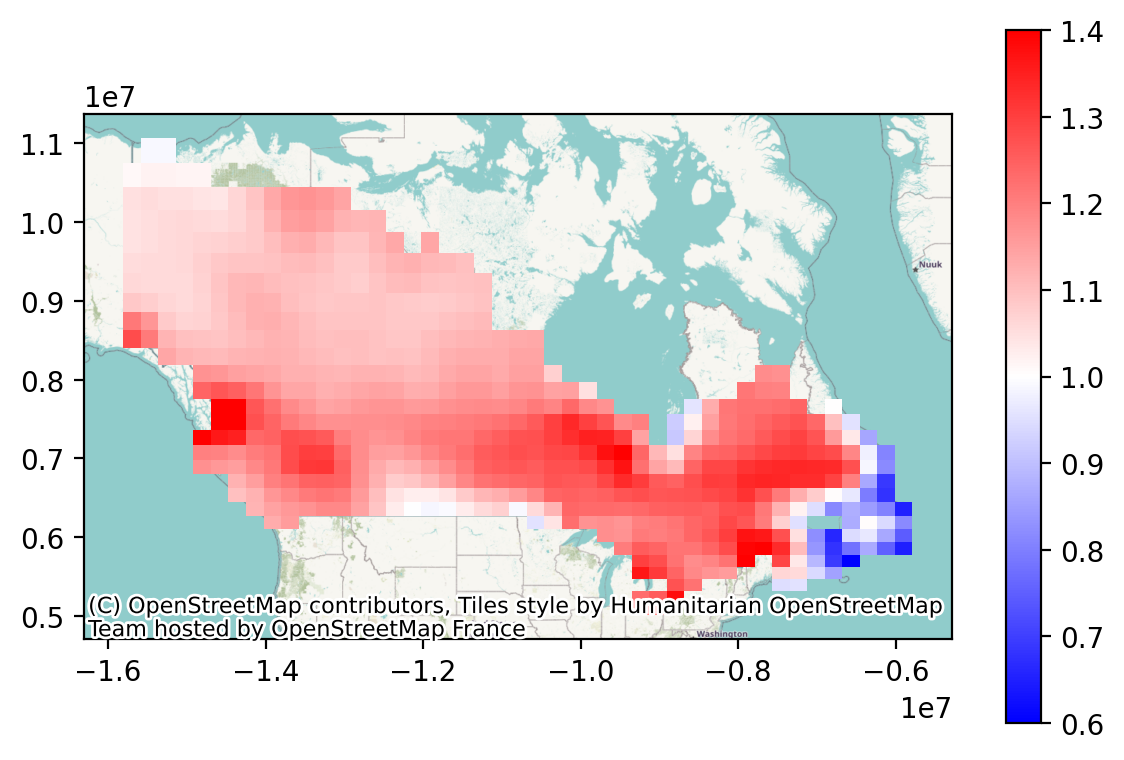

In [64]:
#Mapping for sanity check
af_df.to_crs('epsg:3857',inplace=True)
fig,ax=plt.subplots(figsize=(7,4.5), dpi=200)
af_df.plot(ax=ax, column="Adj_fac_sm",vmin=.6,vmax=1.4,legend=True,cmap='bwr')
cx.add_basemap(ax, zoom=4)

In [ ]:
af_df=gpd.read_file("C:\\Users\\GiovanniCorti\\Documents\\shp_files\\cc_adj_fact.shp")

#Adjust SEDs and igns using smoothed adjustment factor
for index,row in af_df.iterrows():
    NTS_code=row['NTS_SNRC']
    print(NTS_code)
    ign_df=pd.read_csv("Z:\\BP3Inputs\\"+NTS_code+"\\ign_dist_"+NTS_code+".csv")
    sed_df=pd.read_csv("Z:\\BP3Inputs\\"+NTS_code+"\\sed_dist_"+NTS_code+".csv")
    
    cc_ign_avg=np.sum(ign_df["ign_per_it"]*ign_df['pct']/100)*row['Adj_fac_sm']
    cc_sed_avg=np.sum(sed_df["sp_ev_days"]*sed_df['pct']/100)*row['Adj_fac_sm']
    
    ign_val_ls=[np.floor(cc_ign_avg),np.floor(cc_ign_avg)+1]
    ign_rf_ls=[100*np.round(1-cc_ign_avg%1,2),100*np.round(cc_ign_avg%1,2)]
    
    sed_val_ls=[np.floor(cc_sed_avg),np.floor(cc_sed_avg)+1]
    sed_rf_ls=[100*np.round(1-cc_sed_avg%1,2),100*np.round(cc_sed_avg%1,2)]
    
    cc_ign_df=pd.DataFrame({'ign_per_it':np.int8(ign_val_ls),'pct':np.int8(ign_rf_ls)})
    cc_SED_df=pd.DataFrame({'sp_ev_days':np.int8(sed_val_ls),'pct':np.int8(sed_rf_ls)})
    
    if cc_sed_avg<1:
        cc_SED_df=pd.DataFrame({'sp_ev_days':np.int8([1]),'pct':np.int8([100])})

    #Write out ign and SED values to Azure file storage
    cc_ign_df.to_csv("Z:\\BP3Inputs\\"+NTS_code+"\\ign_dist_"+NTS_code+"_ssp1262040_2060.csv",index=False)
    cc_SED_df.to_csv("Z:\\BP3Inputs\\"+NTS_code+"\\sed_dist_"+NTS_code+"_ssp1262040_2060.csv",index=False)
    